In [146]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def format_csv(path : str):
    dataset_input  = pd.read_csv(path)
    domains_unique = dataset_input['domain'].unique()
    output_dict = {'timestamp':list()}
    for domain in domains_unique: output_dict[domain]=list()
    for timestamp in dataset_input['timestamp'].unique():
        x = dataset_input.loc[dataset_input['timestamp'] == timestamp]
        output_dict['timestamp'].append(timestamp)
        for domain in domains_unique: 
            serie = x.loc[x['domain'] == domain]['measure']
            output_dict[domain].append(serie.iloc[0]) if len(serie)>0 else output_dict[domain].append(None)
    return pd.DataFrame(output_dict)

In [34]:
dataset_gt  = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230714-nopin.csv')
dataset_oc3 = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230825-oc3-activecores.csv')

dataset_smt  = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230829-stress-smt.csv')
dataset_soc = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230829-stress-socket.csv')

dataset = dataset.drop(dataset[dataset['timestamp'] > 45000].index)
domains_unique = dataset['domain'].unique()
for domain in domains_unique: print(domain)

libvirt_vm_count
libvirt_vm_cpu_cml
libvirt_vm_mem_cml
package-1
core-0
package-0
core-1
package-global
cpu%_package-global
cpu%_package-1
cpu%_package-0


In [4]:
dataset.head()

,timestamp,domain,measure
0,3,package-1,45.25963
1,3,core-0,0.00450
2,3,package-0,47.38120
3,3,core-1,0.00006
4,3,package-global,92.64083


# Global consumption

In [21]:
package_domains_watt = list()
for domain in domains_unique: 
    if domain.startswith('package-'): package_domains_watt.append(domain)

In [ ]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))

ax = sns.lineplot(data=dataset.loc[dataset['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

x = dataset.loc[dataset['domain'] == 'package-global']
joule1 = x['measure'].sum()*10
print(joule1)

4365710.6808


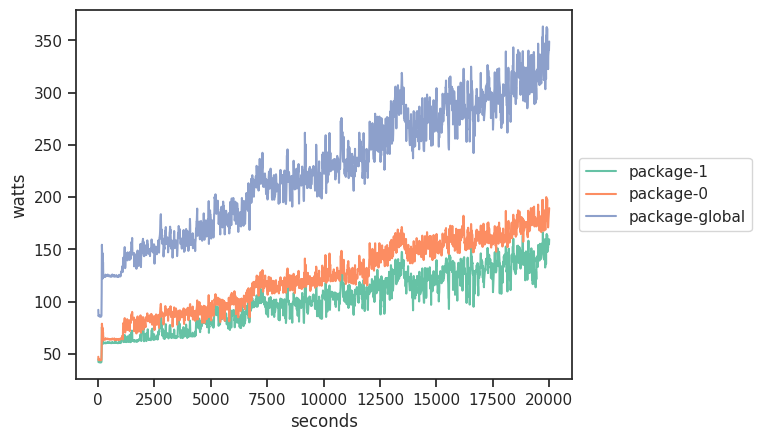

In [19]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))
ax = sns.lineplot(data=dataset.loc[dataset['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

x = dataset.loc[dataset['domain'] == 'package-global']
joule1 = x['measure'].sum()*10
print(joule1)

16026476.276099999


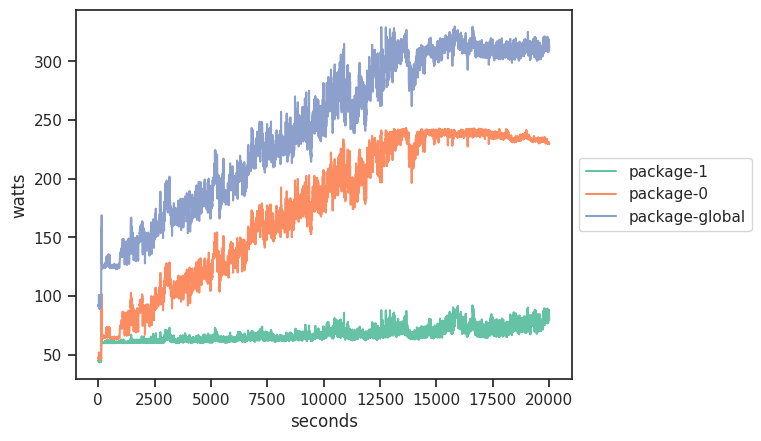

In [17]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))
ax = sns.lineplot(data=dataset.loc[dataset['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

x = dataset.loc[dataset['domain'] == 'package-global']
joule1 = x['measure'].sum()*10
print(joule1)

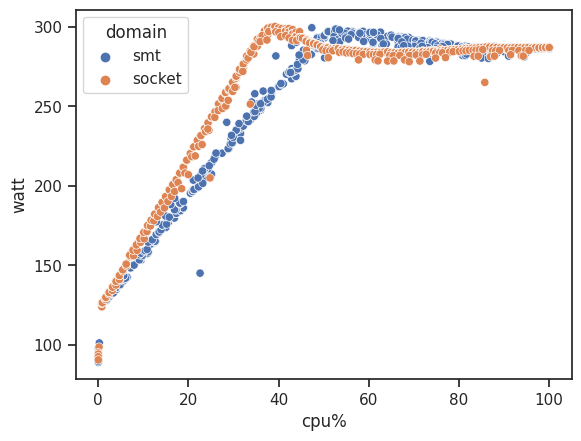

In [89]:
pd.set_option('mode.chained_assignment', None)

x1 = dataset_smt.loc[dataset_smt['domain'] == 'cpu%_package-0']
x1['domain'] = x1['domain'].apply(lambda x : 'smt')
x1.rename(columns={'measure': 'cpu%'}, inplace=True)

x1p = dataset_smt.loc[dataset_smt['domain'] == 'package-global']
x1p['domain'] = x1p['domain'].apply(lambda x : 'smt')
x1p.rename(columns={'measure': 'watt'}, inplace=True)

x1_f = pd.merge(x1.drop(columns = ['domain']), x1p, on=['timestamp'])

x2 = dataset_soc.loc[dataset_soc['domain'] == 'cpu%_package-0']
x2['domain'] = x2['domain'].apply(lambda x : 'socket')
x2.rename(columns={'measure': 'cpu%'}, inplace=True)

x2p = dataset_soc.loc[dataset_soc['domain'] == 'package-global']
x2p['domain'] = x2p['domain'].apply(lambda x : 'socket')
x2p.rename(columns={'measure': 'watt'}, inplace=True)

x2_f = pd.merge(x2.drop(columns = ['domain']), x2p, on=['timestamp'])

output = pd.concat([x1_f,x2_f])


ax = sns.scatterplot(data=output, x='cpu%', y='watt', hue='domain')

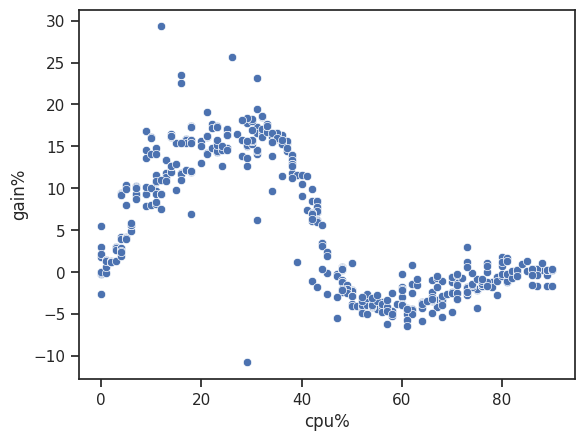

In [104]:
pd.set_option('mode.chained_assignment', None)

x1 = dataset_smt.loc[dataset_smt['domain'] == 'cpu%_package-0']
x1['domain'] = x1['domain'].apply(lambda x : 'smt')
x1.rename(columns={'measure': 'cpu%'}, inplace=True)

x1p = dataset_smt.loc[dataset_smt['domain'] == 'package-global']
x1p['domain'] = x1p['domain'].apply(lambda x : 'smt')
x1p.rename(columns={'measure': 'watt_smt'}, inplace=True)

x1_f = pd.merge(x1.drop(columns = ['domain']), x1p, on=['timestamp'])

x2 = dataset_soc.loc[dataset_soc['domain'] == 'cpu%_package-0']
x2['domain'] = x2['domain'].apply(lambda x : 'socket')
x2.rename(columns={'measure': 'cpu%'}, inplace=True)

x2p = dataset_soc.loc[dataset_soc['domain'] == 'package-global']
x2p['domain'] = x2p['domain'].apply(lambda x : 'socket')
x2p.rename(columns={'measure': 'watt_soc'}, inplace=True)

x2_f = pd.merge(x2.drop(columns = ['domain']), x2p, on=['timestamp'])

output = pd.merge(x1_f, x2_f, on=['timestamp'])

output['cpu%'] = output['cpu%_x'].apply(lambda x : int(x))
output['gain'] = output['watt_soc'] - output['watt_smt']
output['gain%'] = output['gain']/output['watt_soc']*100


output = output.drop(output[output['timestamp'] > 1800].index)
ax = sns.scatterplot(data=output, x='cpu%', y='gain%')

In [98]:
output.head(n=200)

,timestamp,cpu%_x,domain_x,watt_smt,cpu%_y,domain_y,watt_soc
0,3,0.00521,smt,91.27706,0.01037,socket,94.13620
1,6,0.00521,smt,91.05390,0.01042,socket,92.75132
2,9,0.00521,smt,88.90186,0.00780,socket,94.08399
3,12,0.00780,smt,89.65523,0.00779,socket,91.68174
4,15,0.23360,smt,101.18528,0.16922,socket,98.59875
...,...,...,...,...,...,...,...
195,600,29.79427,smt,228.24196,30.58854,socket,269.03927
196,603,29.84815,smt,228.88637,30.54627,socket,262.06059
197,606,31.34084,smt,233.33995,31.34929,socket,271.44750
198,609,31.33854,smt,233.59512,31.35156,socket,273.31424


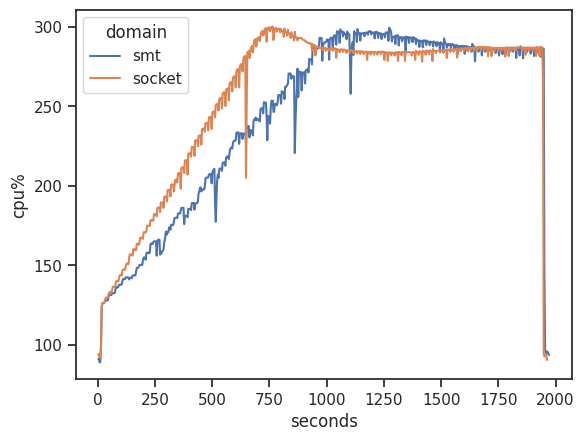

In [68]:
pd.set_option('mode.chained_assignment', None)
x1 = dataset_smt.loc[dataset_smt['domain'] == 'package-global']
x1['domain'] = x1['domain'].apply(lambda x : 'smt')

x2 = dataset_soc.loc[dataset_soc['domain'] == 'package-global']
x2['domain'] = x2['domain'].apply(lambda x : 'socket')

output = pd.concat([x1,x2])
ax = sns.lineplot(data=output, x='timestamp', y='measure', hue='domain')
g = ax.set(xlabel='seconds', ylabel='cpu%')

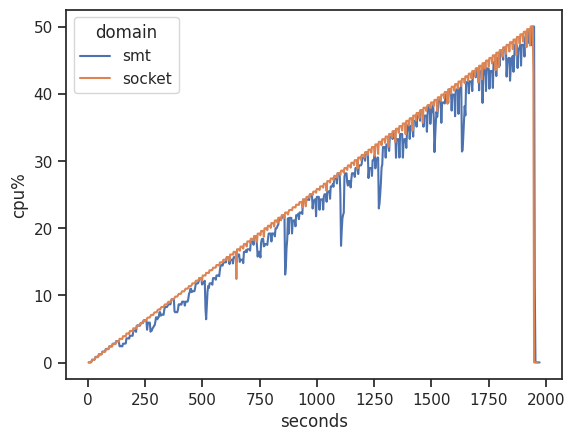

In [63]:
pd.set_option('mode.chained_assignment', None)
x1 = dataset_smt.loc[dataset_smt['domain'] == 'cpu%_package-global']
x1['domain'] = x1['domain'].apply(lambda x : 'smt')

x2 = dataset_soc.loc[dataset_soc['domain'] == 'cpu%_package-global']
x2['domain'] = x2['domain'].apply(lambda x : 'socket')

output = pd.concat([x1,x2])
ax = sns.lineplot(data=output, x='timestamp', y='measure', hue='domain')
g = ax.set(xlabel='seconds', ylabel='cpu%')

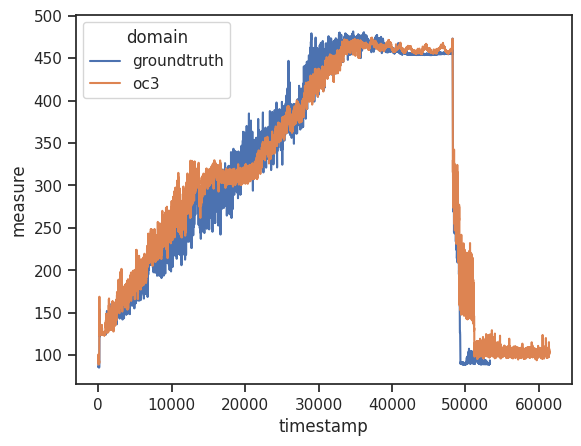

In [33]:
pd.set_option('mode.chained_assignment', None)
x1 = dataset_gt.loc[dataset_gt['domain'] == 'package-global']
x1['domain'] = x1['domain'].apply(lambda x : 'groundtruth')

x2 = dataset_oc3.loc[dataset_oc3['domain'] == 'package-global']
x2['domain'] = x2['domain'].apply(lambda x : 'oc3')

output = pd.concat([x1,x2])
ax = sns.lineplot(data=output, x='timestamp', y='measure', hue='domain')

# Global usage

On a multisocket environment, a socket being used at 100% is not at the same scale than the system being used at 100%. We therefore normalise it by the number of core being used

In [7]:
core_per_socket = 128
total_core = 256

In [8]:
package_domains_usage = list()
to_exclude = list()
for domain in domains_unique: 
    if domain.startswith('cpu%'): package_domains_usage.append(domain)
    else: to_exclude.append(domain)

usage_dataset = dataset.drop(dataset[dataset.domain.isin(to_exclude)].index)
usage_dataset['measure'] = usage_dataset.apply(lambda row : (row['measure']/100)*total_core if 'global' in row['domain'] else (row['measure']/100)*core_per_socket, axis=1)

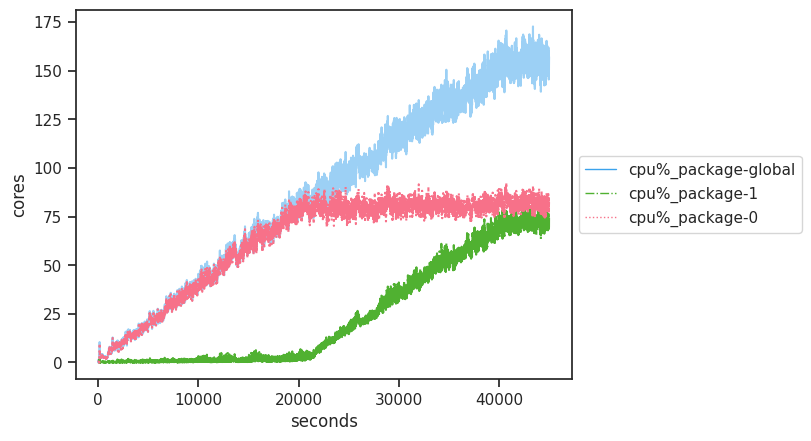

In [9]:
from matplotlib.lines import Line2D
sns.set_theme(style="ticks")
colors = list(sns.color_palette("husl", len(package_domains_usage)))
colors.reverse()
linestyles = ["-","-.",":","--"]
alpha = [0.5, 1 ,1, 1]

ax = plt.subplot()
package_domains_usage.sort(reverse=True)
handlers = list()
for index, domain in enumerate(package_domains_usage):
    filtered_dataset = usage_dataset.loc[usage_dataset['domain'] == domain]
    handlers.append(Line2D([0], [0], color=colors[index], linewidth=1, linestyle=linestyles[index]))
    sns.lineplot(data=filtered_dataset, x='timestamp', y='measure', color=colors[index], linestyle=linestyles[index], alpha=alpha[index], ax=ax, legend=None)

x = plt.legend(handlers, package_domains_usage, loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='cores')
plt.show()

# Link usage to consumption

In [17]:
dataset_labeled = dataset.copy()
dataset_labeled['label'] = dataset_labeled['domain'].apply(lambda name : name.replace('cpu%_', '') if 'package-' in name else None)
dataset_labeled.dropna(inplace=True)
labeled_domains_unique = dataset_labeled['domain'].unique()
labeled_label_unique   = dataset_labeled['label'].unique()

In [18]:
package_domains_watt  = list()
package_domains_usage = list()
for domain in labeled_domains_unique: 
    if domain.startswith('package-'): package_domains_watt.append(domain)
    if domain.startswith('cpu%'):     package_domains_usage.append(domain)

package_domains_usage = ['cpu%_package-global'] # To only display global usage
        
labeled_watt = dataset_labeled.loc[dataset_labeled['domain'].isin(package_domains_watt)]
labeled_usage = dataset_labeled.loc[dataset_labeled['domain'].isin(package_domains_usage)]

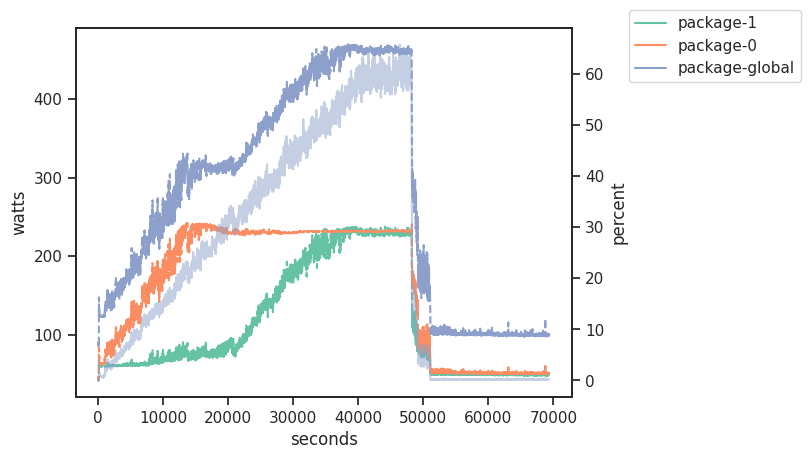

In [19]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(labeled_label_unique))

ax1  = sns.lineplot(data=labeled_watt, x='timestamp', y='measure', linestyle='--', hue='label', hue_order=labeled_label_unique, palette=palette)
ax1.set(xlabel='seconds', ylabel='watts')
ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.95))

ax2 = ax1.twinx()
sns.lineplot(data=labeled_usage, x='timestamp', y='measure', alpha  = 0.5, linestyle='-', hue='label', hue_order=labeled_label_unique, legend=False, palette=palette, ax=ax2)
g = ax2.set(ylabel='percent')

# Libvirt metrics

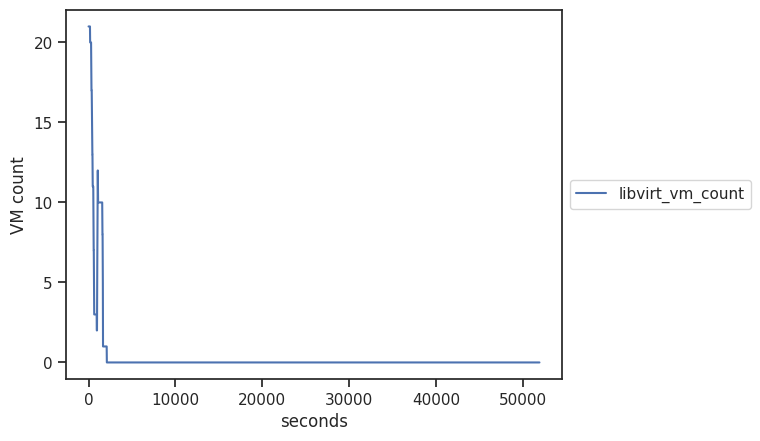

In [14]:
ax = sns.lineplot(data=dataset.loc[dataset['domain'] == 'libvirt_vm_count'], x='timestamp', y='measure', hue='domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='VM count')

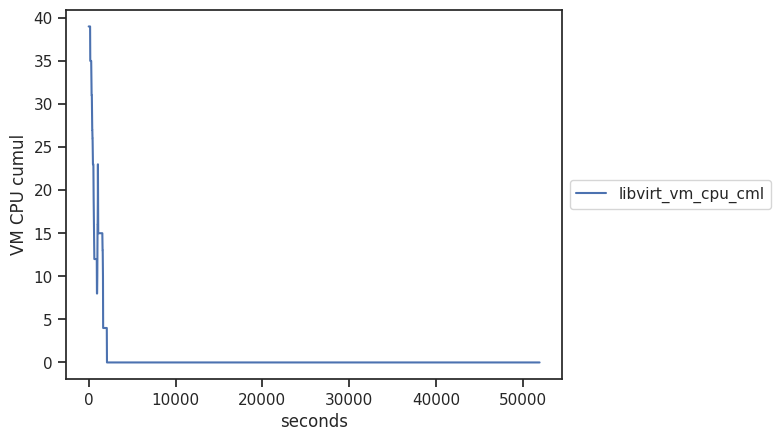

In [15]:
ax = sns.lineplot(data=dataset.loc[dataset['domain'] == 'libvirt_vm_cpu_cml'], x='timestamp', y='measure', hue='domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='VM CPU cumul')

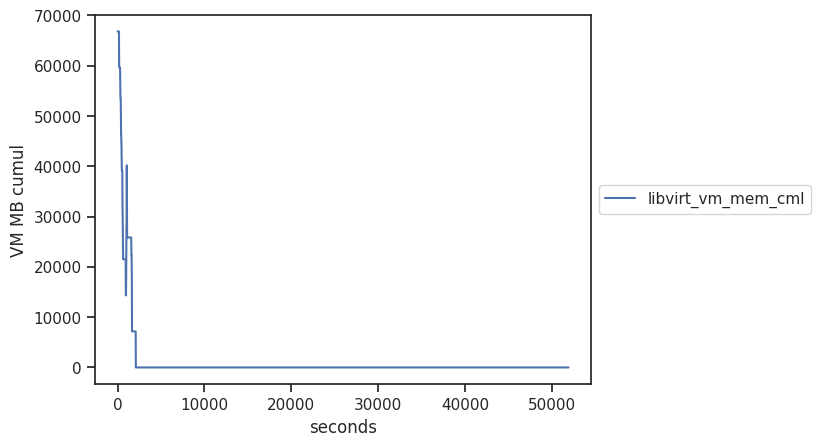

In [16]:
ax = sns.lineplot(data=dataset.loc[dataset['domain'] == 'libvirt_vm_mem_cml'], x='timestamp', y='measure', hue='domain')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='VM MB cumul')

# Experiment zone

In [4]:
dataset_nopin = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230714-nopin.csv')
#dataset_oc1 = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230715-oc1.csv')
dataset_oc3 = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230717-oc3-fixed.csv')
domains_unique = dataset_nopin['domain'].unique()

In [5]:
package_domains_watt = list()
for domain in domains_unique: 
    if domain.startswith('package-'): package_domains_watt.append(domain)

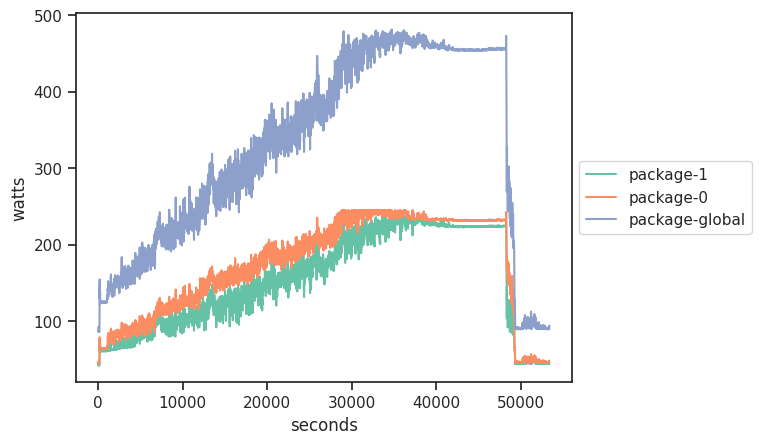

In [9]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))
ax = sns.lineplot(data=dataset_nopin.loc[dataset_nopin['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

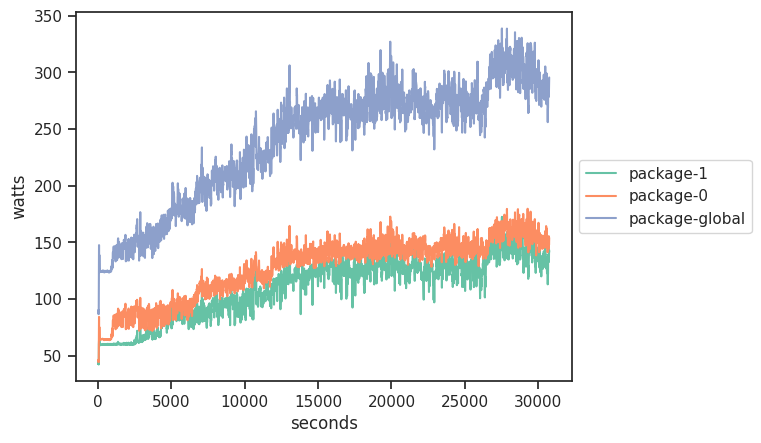

In [10]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))
ax = sns.lineplot(data=dataset_oc1.loc[dataset_oc1['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

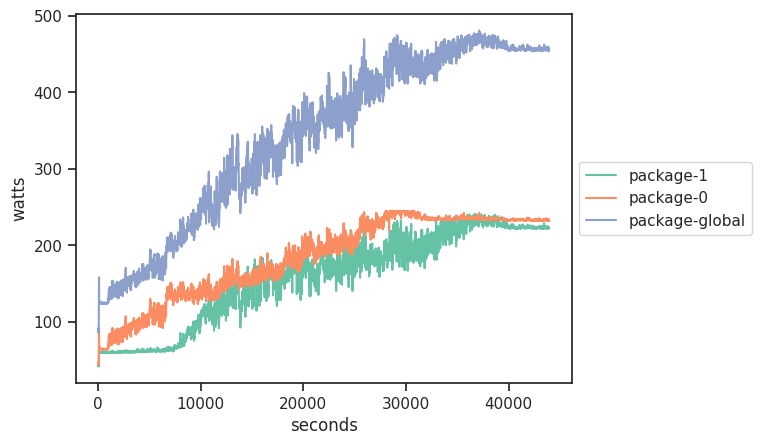

In [11]:
sns.set_theme(style="ticks")
palette = sns.color_palette("Set2", len(package_domains_watt))
ax = sns.lineplot(data=dataset_oc3.loc[dataset_oc3['domain'].isin(package_domains_watt)], x='timestamp', y='measure', hue='domain', palette=palette)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g = ax.set(xlabel='seconds', ylabel='watts')

In [6]:
keys = ['package-global', 'libvirt_vm_count', 'libvirt_vm_cpu_cml', 'libvirt_vm_mem_cml']

dataset_nopin_labeled = dataset_nopin.loc[dataset_nopin['domain'].isin(keys)]
dataset_nopin_labeled['label'] = dataset_nopin_labeled['domain'].apply(lambda x : 'nopin')

#dataset_oc1_labeled = dataset_oc1.loc[dataset_oc1['domain'].isin(keys)]
#dataset_oc1_labeled['label'] = dataset_oc1_labeled['domain'].apply(lambda x : 'oc1')

dataset_oc3_labeled = dataset_oc3.loc[dataset_oc3['domain'].isin(keys)]
dataset_oc3_labeled['label'] = dataset_oc3_labeled['domain'].apply(lambda x : 'oc3')

/tmp/ipykernel_98900/906510884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_nopin_labeled['label'] = dataset_nopin_labeled['domain'].apply(lambda x : 'nopin')
/tmp/ipykernel_98900/906510884.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_oc3_labeled['label'] = dataset_oc3_labeled['domain'].apply(lambda x : 'oc3')


In [8]:
energy = list()
count = list()
label = list()

for df in [dataset_nopin_labeled, dataset_oc3_labeled]:
    for timestamp in df['timestamp'].unique():

        df_tmp  = df.loc[df['timestamp'] == timestamp]

        package_global = df_tmp.loc[df_tmp['domain'] == 'package-global']
        vm_count = df_tmp.loc[df_tmp['domain'] == 'libvirt_vm_count']

        if package_global.empty: continue # overflow or first val
        if vm_count.empty: print('missing count vm') # error

        energy.append(package_global['measure'].iloc[0])
        count.append(vm_count['measure'].iloc[0])
        label.append(vm_count['label'].iloc[0])

concat_df = pd.DataFrame({'vm_count':count, 'watts':energy, 'label':label})

In [14]:
concat_df.head()

,vm_count,watts,label
0,0.0,92.03723,nopin
1,0.0,86.06384,nopin
2,0.0,86.58783,nopin
3,0.0,86.23704,nopin
4,0.0,86.75353,nopin


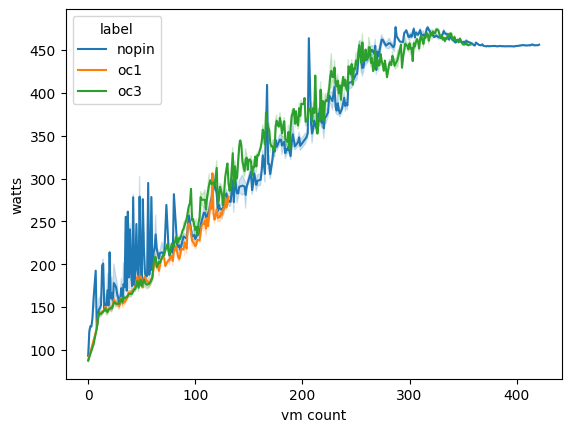

In [23]:
ax = sns.lineplot(data=concat_df, x='vm_count', y='watts', hue='label')
g = ax.set(xlabel='vm count', ylabel='watts')

# Correctif

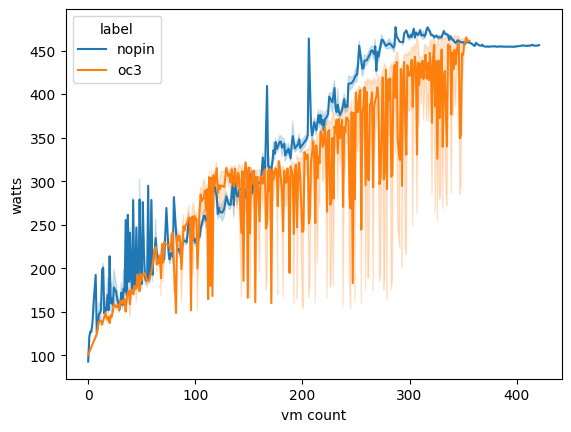

In [9]:
ax = sns.lineplot(data=concat_df, x='vm_count', y='watts', hue='label')
g = ax.set(xlabel='vm count', ylabel='watts')

# Correctif2

In [2]:
dataset_oc1 = pd.read_csv('/usr/local/src/rapl-reader/measures/consumption-20230824-oc1-activecores.csv')